**Forecasting (Coco Cola Sales)**

In [103]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

**Loading and Analysing data by line plot**

In [104]:
data=pd.read_excel('/content/CocaCola_Sales_Rawdata.xlsx')
data.head(12)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [105]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


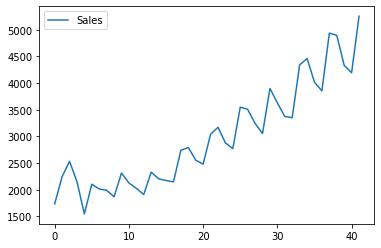

In [106]:
data.plot();
pyplot.show()

**We can see there is increasing trend and we can also say there is seasonality as well.**

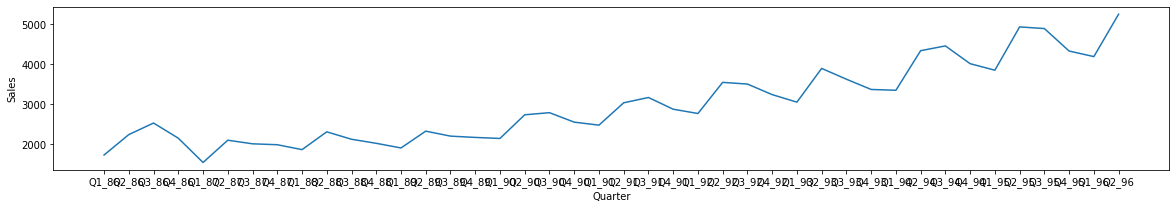

In [107]:
#Line plot
plt.figure(figsize=(20,3))
sns.lineplot(x="Quarter",y="Sales",data=data);

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


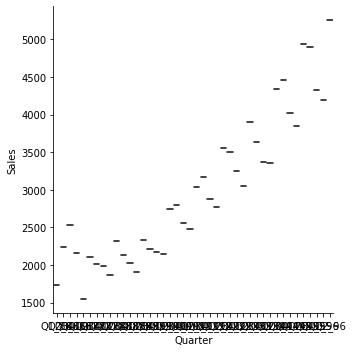

In [108]:
sns.factorplot("Quarter","Sales",data=data,kind="box");

**Data Pre Processing**

In [109]:
quarter=['Q1','Q2','Q3','Q4']
n=data['Quarter'][0]
n[0:2]

data['quarter']=0

In [110]:
for i in range(42):
    n=data['Quarter'][i]
    data['quarter'][i]=n[0:2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [111]:
dummy=pd.DataFrame(pd.get_dummies(data['quarter']))
dummy.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [112]:
# adding t and t_square columns to dataset
coco=pd.concat((data,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [113]:
coco.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_square
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25


In [114]:
# Adding log_sales to dataset
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales
coco.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_square,log_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602


In [115]:
# Splitting data to train and test (validation)

In [116]:
Train= coco.head(37)
Test=coco.tail(5)

**Model Based Approch (Buliding Models)**

In [117]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

737.1568992951951

In [118]:
#Exponential

Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

586.8646090003102

In [119]:
#Quadratic 

Quad = smf.ols('Sales~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

445.8029895177927

In [120]:
#Additive seasonality 

add_sea = smf.ols('Sales~ Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1931.36279040632

In [121]:
#Additive Seasonality with Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

252.2557608176047

In [122]:
#additive seasonality with linear trend
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=Train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(Test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmse_add_linear=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(predaddlinear))**2))
rmse_add_linear

572.3530370243457

In [123]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(pd.DataFrame(Test[['Q1','Q2','Q3','Q4']])))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

2023.7328645103598

In [124]:
#multiplicative seasonality with linear trend
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=Train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(Test[['t','Q1','Q2','Q3','Q4']])))
rmse_mu_lin=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(predmullin)))**2))
rmse_mu_lin

290.26847888864995

In [125]:
#multiplicative seasonality with quadratic trend
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=Train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(Test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

594.3833855598255

In [126]:
# Tabulating Models with their RMSE values
Models = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad",'rmse_add_linear',"rmse_Mult_sea",'rmse_mu_lin',"rmse_mul_quad"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_add_linear,rmse_Mult_sea,rmse_mu_lin,rmse_mul_quad])}
table_rmse=pd.DataFrame(Models)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,252.255761
7,rmse_mu_lin,290.268479
2,rmse_Quad,445.802990
5,rmse_add_linear,572.353037
1,rmse_Exp,586.864609
8,rmse_mul_quad,594.383386
0,rmse_linear,737.156899
3,rmse_add_sea,1931.362790
6,rmse_Mult_sea,2023.732865


1.We can see Additive Seasonality with Quadratic trend model has least RMSE value compared to other models .


2.In these above models we used in-sampleing as there are no out-samples given to forecast.


3.These models are likely to consider the previous trend and seasonality and the forecasted values also follow the previos pattern.


4.The data give here is a volatile data because a small policy can bring drastic change in the sales, sometimes these models may lead to error because these models have a approch as past is similar to future.


5.In these volatile conditions always future is not dependend on past values or trend .



6.So, we have to consider Data Driven Models as well



* We can use these model where there are no major changes in data, for example in finance sector of insurance payments in a well developed country.

**Data Driven Models**

In [127]:
#Moving Average

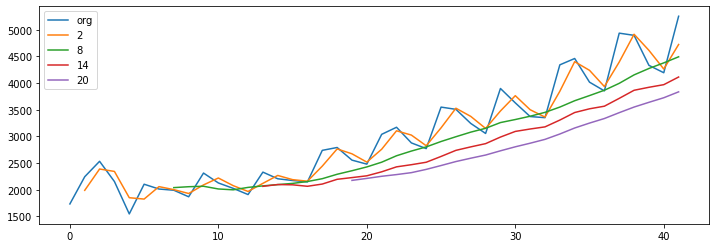

In [128]:
plt.figure(figsize=(12,4))
coco.Sales.plot(label="org")
for i in range(2,24,6):
    coco["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [129]:
# ACF plots and PACF plots

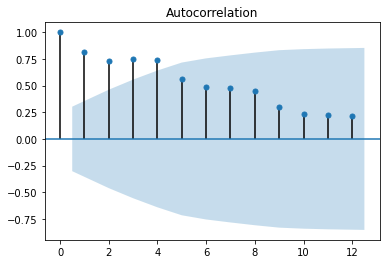

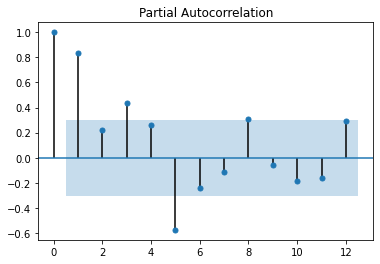

In [130]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(coco.Sales,lags=12)
tsa_plots.plot_pacf(coco.Sales,lags=12)
plt.show()

In [131]:
# MAPE 
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [132]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(Train['Sales']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

19.12727544457338

In [133]:
# Holt method 
hw_model = Holt(Train['Sales']).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

14.286062827267376

In [134]:
#Holts winter exponential smoothing with additive seasonality and additive trend

hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


4.2521831635724165

In [135]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend

hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


3.639952023932765

* In above models Holts winter exponential smoothing with multiplicative seasonality and additive trend has least MAPE value so we can consider it as better model.

* These models have approch as past is not similar to future.

In [136]:
# Final Modelbuilding with train+test data

In [137]:
hwe_model_mul_add_final = ExponentialSmoothing(coco["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [138]:
#Forecasting for next 10 time periods
hwe_model_mul_add_final.forecast(15)

42    4923.825834
43    4585.806901
44    4530.662095
45    5759.370929
46    5819.152426
47    5203.721006
48    4956.155622
49    6256.502400
50    6107.476878
51    5463.902671
52    5266.754892
53    6577.688511
54    6134.418921
55    5690.656273
56    5600.741202
dtype: float64

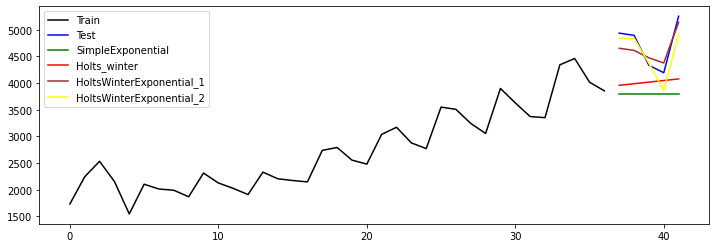

In [139]:
# Visualization of Forecasted values for Test data set using different methods 
plt.figure(figsize=(12,4))
plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best');

In [140]:
# ARIMA model

In [141]:
from statsmodels.tsa.arima_model import ARIMA

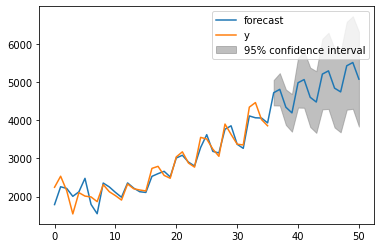

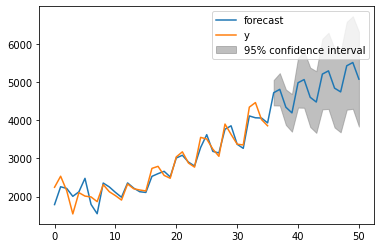

In [142]:
X = Train.Sales.values
X = X.astype('float32')
model = ARIMA(X, order=(4,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 51)

In [143]:
# Error with test data
from sklearn.metrics import mean_squared_error
from math import sqrt
y=Test.Sales.values
y=y.astype('float32')
rmse = sqrt(mean_squared_error(y, forecast[0:5]))
rmse

160.66302135821942

In [144]:
forecast

array([4719.32796755, 4807.25367626, 4340.27689638, 4191.52093352,
       4980.31383204, 5063.21109303, 4599.17314297, 4475.55074522,
       5206.76245535, 5290.77987519])

ARIMA model has better RMSE value than Model Based Approaches

**Forecasting (Airlines data)**

**Loading and Analysing data by line plot**

In [145]:
air=pd.read_excel('/content/Airlines+Data.xlsx')
air

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


**This is airlines data of no.of passengers boarding every month from januaty 1995 to december 2002.**

In [146]:
# Parse strings to datetime type

from datetime import datetime
air['Month'] = pd.to_datetime(air['Month'], infer_datetime_format=True)
indexedDataset = air.set_index(['Month'])

In [147]:
indexedDataset['1995-03']
indexedDataset['1995-03':'1995-06']
indexedDataset['1995']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
1995-06-01,135
1995-07-01,148
1995-08-01,148
1995-09-01,136


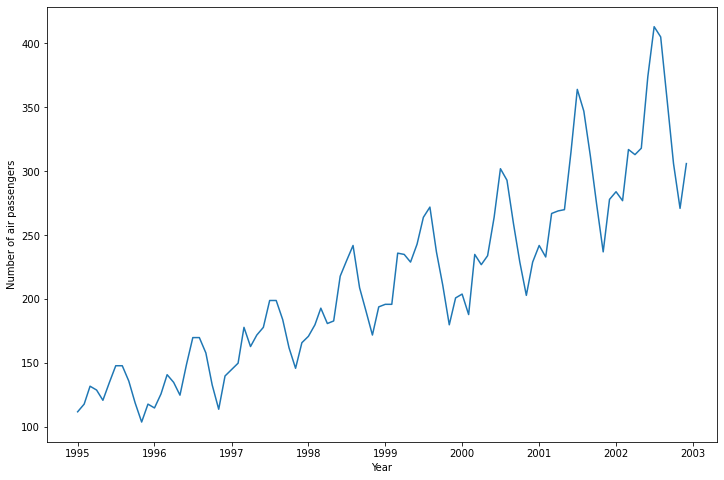

In [148]:
plt.figure(figsize=(12,8))
plt.xlabel("Year")
plt.ylabel("Number of air passengers")
plt.plot(indexedDataset)

**Given data has increasing trend and seasonality.**

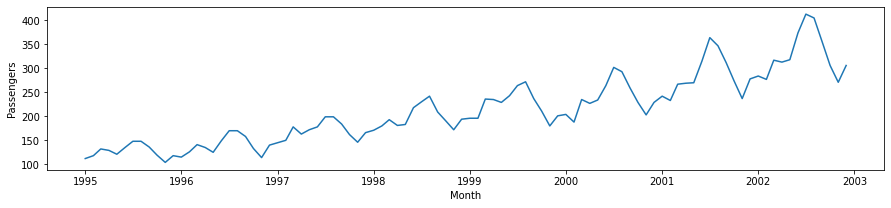

In [149]:
#Line plot

plt.figure(figsize=(15,3))
sns.lineplot(x="Month",y="Passengers",data=indexedDataset);

<Figure size 576x864 with 0 Axes>

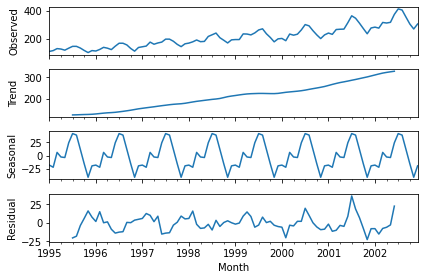

In [150]:
plt.figure(figsize=(8,12))
decompose_ts_add = seasonal_decompose(indexedDataset.Passengers)
decompose_ts_add.plot()
plt.show();

**In the above plot we can clearly see trend and sesonality of data**

*This is also a volatile data we can go for Data Driven Models

*There maybe drastic change of passengers travel because of countries visa policy.

In [151]:
# Splitting data into Train and Test
Train=indexedDataset.head(90)
Test=indexedDataset.tail(6)

In [152]:
Train

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-02-01,277
2002-03-01,317
2002-04-01,313


In [153]:
Test

,Passengers
Month,
2002-07-01,413
2002-08-01,405
2002-09-01,355
2002-10-01,306
2002-11-01,271
2002-12-01,306


**Data Driven Models**

In [154]:
# Moving Average

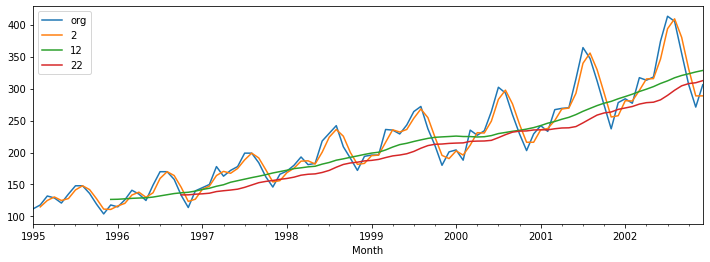

In [155]:
plt.figure(figsize=(12,4))
indexedDataset.Passengers.plot(label="org")
for i in range(2,24,10):
    indexedDataset["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [156]:
# ACF plots and PACF plots

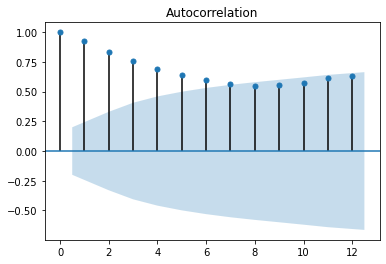

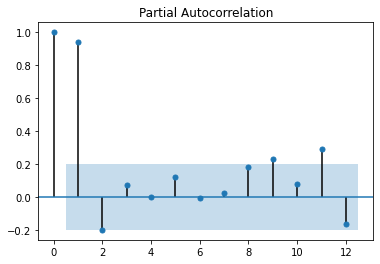

In [157]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(indexedDataset.Passengers,lags=12)
tsa_plots.plot_pacf(indexedDataset.Passengers,lags=12)
plt.show()

In [158]:
# MAPE 
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [159]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(Train['Passengers']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


13.161170526223493

In [160]:
# Holt method 
hw_model = Holt(Train['Passengers']).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


27.619306276788702

In [161]:
#Holts winter exponential smoothing with additive seasonality and additive trend

hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2.3842203102653334

In [162]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend

hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2.8309640009827923

* In above models Holts winter exponential smoothing with additive seasonality and additive trend has least MAPE value (2.384) so we can consider it as better model.

* These models have approch as past is not similar to future.

In [163]:
# Final Modelbuilding with train+test data

In [164]:
hwe_model_add_add_final = ExponentialSmoothing(indexedDataset["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [165]:
#Forecasting for next 10 time periods
hwe_model_add_add_final.forecast(15)

2003-01-01    320.924021
2003-02-01    313.638039
2003-03-01    352.925020
2003-04-01    350.350301
2003-05-01    356.060923
2003-06-01    408.899129
2003-07-01    446.143114
2003-08-01    433.358026
2003-09-01    382.762460
2003-10-01    336.170254
2003-11-01    303.315050
2003-12-01    349.662471
2004-01-01    356.109876
2004-02-01    348.823895
2004-03-01    388.110875
Freq: MS, dtype: float64

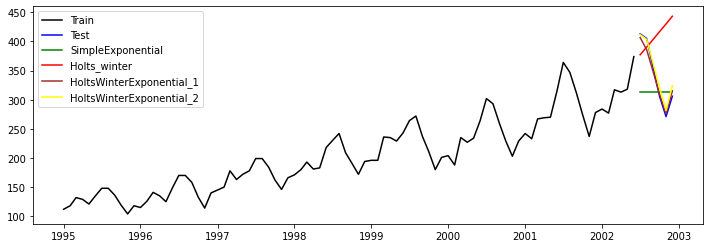

In [166]:
# Visualization of Forecasted values for Test data set using different methods 
plt.figure(figsize=(12,4))
plt.plot(Train.index, Train["Passengers"], label='Train',color="black")
plt.plot(Test.index, Test["Passengers"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best');

In [167]:
# Arima Model

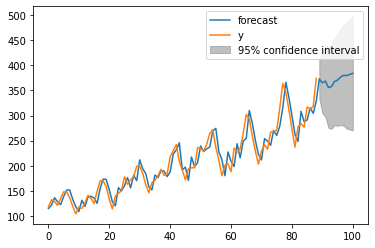

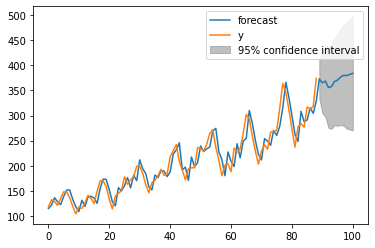

In [168]:
X = Train.Passengers.values
X = X.astype('float32')
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=6)[0]
model_fit.plot_predict(1, 101)

In [169]:
# Error with test data
from sklearn.metrics import mean_squared_error
from math import sqrt
y=Test.Passengers.values
y=y.astype('float32')
rmse = sqrt(mean_squared_error(y, forecast[0:6]))
rmse

53.506893319485805

In [170]:
# Combine train and test data and build final model
# prepare data
final = indexedDataset.Passengers.values
final = final.astype('float32')
model_final = ARIMA(final, order=(5,1,0))
model_fit = model_final.fit()

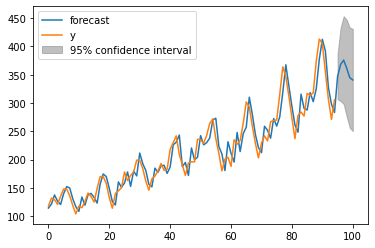

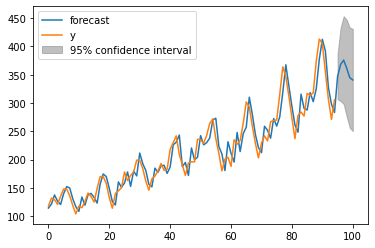

In [171]:
forecast_final=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,101)

In [172]:
forecast_final

array([346.95349551, 368.15875064, 375.80159785, 361.6136709 ,
       344.83396884, 340.75479868, 345.75088787, 356.88527293,
       367.34618987, 371.27585474])